In [1]:
import numpy as np
import pandas as pd

import gc
from sklearn.model_selection import KFold
from cuml.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns

In [2]:
OUTPUT_DICT = ''

ID = 'Id'
TARGET_COLS = ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']
SEED = 2020

N_FOLD = 5

In [3]:
base_path = '/media/hiroki/share/kaggle_data/trends-assessment-prediction/'
train = pd.read_csv(base_path+'train_scores.csv', dtype={'Id':str})\
            #.dropna().reset_index(drop=True) # to make things easy
reveal_ID = pd.read_csv(base_path+'reveal_ID_site2.csv', dtype={'Id':str})
ICN_numbers = pd.read_csv(base_path+'ICN_numbers.csv')
loading = pd.read_csv(base_path+'loading.csv', dtype={'Id':str})
fnc = pd.read_csv(base_path+'fnc.csv', dtype={'Id':str})
sample_submission = pd.read_csv(base_path+'sample_submission.csv', dtype={'Id':str})

In [4]:
fnc_features, loading_features = list(fnc.columns[1:]), list(loading.columns[1:])

In [5]:
sample_submission['ID_num'] = sample_submission[ID].apply(lambda x: int(x.split('_')[0]))
test = pd.DataFrame({ID: sample_submission['ID_num'].unique().astype(str)})
del sample_submission['ID_num']; gc.collect()
test.head()

,Id
0,10003
1,10006
2,10010
3,10011
4,10012


In [6]:
test.head()

,Id
0,10003
1,10006
2,10010
3,10011
4,10012


In [7]:
# merge
train = train.merge(loading, on=ID, how='left')
train = train.merge(fnc, on=ID, how='left')
train

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,IC_01,IC_07,IC_05,IC_16,...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998,0.006070,0.014466,0.004136,0.000658,...,-0.149279,0.552841,0.131046,0.335446,0.394867,-0.042853,0.124627,-0.060712,0.515964,0.290488
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361,0.009087,0.009291,0.007049,-0.002076,...,-0.214216,-0.039792,0.143014,-0.189962,0.498373,0.444231,0.592438,0.028649,0.705524,0.248327
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641,0.004675,0.000957,0.006154,-0.000429,...,-0.130339,0.309540,0.141469,0.030853,0.344394,0.214097,0.317556,0.012435,0.665937,0.081358
3,10005,66.532630,NaN,NaN,52.108977,69.993075,-0.000398,0.006878,0.009051,0.000369,...,-0.139525,0.394932,0.040443,0.428334,0.498837,0.266755,0.227379,0.028984,0.752343,0.087898
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421,0.005192,0.010585,0.012160,-0.000920,...,-0.150218,0.408926,0.072004,0.157582,0.532046,0.355448,0.462675,0.161005,0.703679,0.293607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179,-0.001115,0.007108,0.008652,0.003596,...,-0.249481,0.205351,0.012067,0.310750,0.426335,0.193812,0.158720,0.055471,0.568766,0.160516
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517,0.007263,0.016489,0.012704,0.004357,...,-0.119170,0.201846,-0.008290,0.119828,0.551936,0.598931,0.511816,0.303312,0.704483,0.461588
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885,0.005996,0.003873,0.012353,0.000242,...,-0.103786,0.375065,0.104857,0.262614,0.502715,0.322353,0.458041,0.343754,0.705207,0.341224
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235,0.000627,0.011407,0.010957,0.000534,...,0.229712,0.431489,0.039062,0.119474,0.523894,0.445209,0.332011,0.228977,0.560968,0.263504


In [8]:
# merge
test = test.merge(loading, on=ID, how='left')
test = test.merge(fnc, on=ID, how='left')
test

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10003,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,...,-0.154941,0.136850,-0.022361,0.137625,0.677972,0.409412,0.563892,0.438684,0.618204,0.284474
1,10006,0.000334,0.005311,0.010053,0.006920,-0.000065,0.015310,0.016543,0.004794,0.003982,...,-0.053606,0.240957,0.270419,0.367692,0.354501,0.486364,0.416908,0.285274,0.693490,0.448526
2,10010,0.007103,0.006144,0.009770,-0.002884,-0.001346,0.015651,0.011613,-0.003291,0.013423,...,-0.244332,0.272077,0.193523,0.192254,0.563982,0.124482,0.488926,0.083368,0.774299,0.129327
3,10011,0.004362,0.010240,0.010167,0.004492,-0.001623,0.017381,0.014680,0.007453,0.008786,...,-0.099726,0.557121,0.042626,0.179456,0.416546,0.445402,0.436909,0.165182,0.591561,0.306678
4,10012,-0.007521,-0.003918,0.008434,-0.001145,0.002017,0.015065,0.019616,0.004140,-0.003744,...,-0.025230,0.203298,0.173427,0.046047,0.561599,0.418268,0.609517,0.218285,0.790285,0.301010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21745,0.005406,0.006275,0.012252,0.003518,0.001400,0.015054,0.015373,0.001532,0.003546,...,0.179080,0.580813,0.202241,0.254870,0.458581,0.434638,0.587167,0.009854,0.472956,0.342085
5873,21748,0.004240,0.009213,0.010981,0.000443,-0.003072,0.010702,0.014673,0.005523,0.005780,...,-0.106345,0.234340,0.138985,0.343382,0.708744,0.312812,0.536501,0.214803,0.849512,0.204741
5874,21749,0.004783,0.017910,0.012128,-0.005683,-0.011613,0.017000,0.007230,0.001315,0.008788,...,-0.165575,0.170154,-0.029638,0.383761,0.398305,0.578621,0.357127,0.009479,0.609545,0.317230
5875,21751,0.003835,0.015067,0.015428,-0.002030,0.001205,0.012396,0.011026,-0.001491,0.005310,...,-0.087604,0.131902,-0.047932,0.022317,0.583869,0.596734,0.515209,0.379589,0.568422,0.439016


In [9]:
import IPython

def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [10]:
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [11]:
# Giving less importance to FNC features since they are easier to overfit due to high dimensionality.
FNC_SCALE = 1/600

train[fnc_features] *= FNC_SCALE
test[fnc_features] *= FNC_SCALE

In [12]:
# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def predict_cv(train_x, train_y, test_x, model, target_name):
    preds = []
    preds_test = []
    va_idxes = []
    
    score = []
    mae = []
    rmse = []

    # shuffleしなくても良い
    kf = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx].values, train_x.iloc[va_idx].values
        tr_y, va_y = train_y.iloc[tr_idx].values, train_y.iloc[va_idx].values
        model.fit(tr_x, tr_y)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)
        
        score.append(metric(va_y, pred))
        mae.append(mean_absolute_error(va_y, pred))
        rmse.append(np.sqrt(mean_squared_error(va_y, pred)))
        
    score_cv = np.array(score).mean()
    mae_cv = np.array(mae).mean()
    rmse_cv = np.array(rmse).mean()
    print("{0}_score:{1}".format(target_name, np.round(score_cv, 8)))
    print("{0}_mae:{1}".format(target_name, np.array(mae_cv).mean()))
    print("{0}_rmse:{1}".format(target_name, np.array(rmse_cv).mean()))
    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test, score_cv

# 1st layer

## SVR

In [14]:
import cudf
import cupy as cp
from cuml import SVR

In [15]:
pred_train_targets_svr = {}
pred_test_targets_svr = {}

pred_train_targets_svr_dfs = {}
pred_test_targets_svr_dfs = {}

overal_score = 0

print("N_FOLD:{}".format(N_FOLD))

for target, c, w in [("age", 60, 0.3),
                     ("domain1_var1", 12, 0.175),
                     ("domain1_var2", 8, 0.175),
                     ("domain2_var1", 9, 0.175),
                     ("domain2_var2", 12, 0.175)]:
    
    train_df = train[train[target].notnull()]
    test_df = test
        
    use_idx = train_df.index
    train_x = train_df.drop([ID]+TARGET_COLS, axis=1)
    train_y = train_df[target]
    test_x = test_df.drop(ID, axis=1)
    svr = SVR(C=c, cache_size=3000.0)
    
    print("-----{}-----".format(target))
    pred_train, preds_test, score_cv = predict_cv(train_x, train_y, test_x, svr, target)
    overal_score += w*score_cv
    pred_train_targets_svr[target] = pred_train
    pred_test_targets_svr[target] = preds_test
    
    pred_train_targets_svr_dfs[target] = pd.Series(pred_train, name="pre_svr_{}".format(target), index=use_idx)
    pred_train_targets_svr_dfs[target] = pd.merge(train['Id'],
                                                  pred_train_targets_svr_dfs[target],
                                                  left_index=True,
                                                  right_index=True)
    pred_test_targets_svr_dfs[target] = pd.Series(preds_test, name="pre_svr_{}".format(target))
    pred_test_targets_svr_dfs[target] = pd.concat([test['Id'], pred_test_targets_svr_dfs[target]], axis=1)
    
    
print('--------------------------------------------')
print("Overal score:", np.round(overal_score, 8))

N_FOLD:5
-----age-----
age_score:0.14386585
age_mae:7.197805992588449
age_rmse:9.147440070169111
-----domain1_var1-----
domain1_var1_score:0.15117448
domain1_var1_mae:7.7821543363146235
domain1_var1_rmse:9.704146603836946
-----domain1_var2-----
domain1_var2_score:0.15150079
domain1_var2_mae:8.974771341877382
domain1_var2_rmse:11.44197948977398
-----domain2_var1-----
domain2_var1_score:0.18195558
domain2_var1_mae:8.608609438557298
domain2_var1_rmse:10.934885564728182
-----domain2_var2-----
domain2_var2_score:0.17589358
domain2_var2_mae:9.128640415626789
domain2_var2_rmse:11.735250108597658
--------------------------------------------
Overal score: 0.15875153


In [ ]:
for df in pred_train_targets_svr_dfs.values():
    display(df.describe())

In [ ]:
for df in pred_train_targets_svr_dfs.values():
    display(df)

In [ ]:
pred_test_targets_df = pd.DataFrame(pred_test_targets_svr)

In [ ]:
pred_test_targets_df.describe()

In [ ]:
pred_test_targets_df

## baysian ridge

In [16]:
from sklearn.linear_model import BayesianRidge

In [17]:
pred_train_targets_bayes_ridge = {}
pred_test_targets_bayes_ridge = {}

pred_train_targets_bayes_ridge_dfs = {}
pred_test_targets_bayes_ridge_dfs = {}

overal_score = 0

print("N_FOLD:{}".format(N_FOLD))

for target, w in [("age", 0.3),
                  ("domain1_var1", 0.175),
                  ("domain1_var2", 0.175),
                  ("domain2_var1", 0.175),
                  ("domain2_var2", 0.175)]:
    
    train_df = train[train[target].notnull()]
    test_df = test
    
    use_idx = train_df.index
    train_x = train_df.drop([ID]+TARGET_COLS, axis=1)
    train_y = train_df[target]
    test_x = test_df.drop(ID, axis=1)
    bayes_ridge = BayesianRidge(n_iter = 3000)
    
    print("-----{}-----".format(target))
    pred_train, preds_test, score_cv = predict_cv(train_x, train_y, test_x, bayes_ridge, target)
    overal_score += w*score_cv
    pred_train_targets_bayes_ridge[target] = pred_train
    pred_test_targets_bayes_ridge[target] = preds_test
    
    pred_train_targets_bayes_ridge_dfs[target] = pd.Series(pred_train, name="pre_bayRidge_{}".format(target), index=use_idx)
    pred_train_targets_bayes_ridge_dfs[target] = pd.merge(train['Id'],
                                                 pred_train_targets_bayes_ridge_dfs[target],
                                                 left_index=True,
                                                 right_index=True)
    pred_test_targets_bayes_ridge_dfs[target] = pd.Series(preds_test, name="pre_bayRidge_{}".format(target))
    pred_test_targets_bayes_ridge_dfs[target] = pd.concat([test['Id'], pred_test_targets_bayes_ridge_dfs[target]], axis=1)
print('--------------------------------------------')
print("Overal score:", np.round(overal_score, 8))

N_FOLD:5
-----age-----
age_score:0.14321187
age_mae:7.165049493545401
age_rmse:9.098309269403074
-----domain1_var1-----
domain1_var1_score:0.15090165
domain1_var1_mae:7.768116543260325
domain1_var1_rmse:9.676266347797846
-----domain1_var2-----
domain1_var2_score:0.15118597
domain1_var2_mae:8.956318292986733
domain1_var2_rmse:11.36979535814944
-----domain2_var1-----
domain2_var1_score:0.18193697
domain2_var1_mae:8.60787614389697
domain2_var1_rmse:10.890245631729742
-----domain2_var2-----
domain2_var2_score:0.17665334
domain2_var2_mae:9.168203560911689
domain2_var2_rmse:11.70805955311791
--------------------------------------------
Overal score: 0.1585822


In [18]:
for df in pred_train_targets_bayes_ridge_dfs.values():
    display(df.describe())

,pre_bayRidge_age
count,5877.000000
mean,50.038717
std,10.038128
min,19.518356
25%,42.842211


,pre_bayRidge_domain1_var1
count,5439.000000
mean,51.492404
std,3.185482
min,40.796837
25%,49.327597


,pre_bayRidge_domain1_var2
count,5439.000000
mean,59.245596
std,0.645455
min,56.373948
25%,58.836050


,pre_bayRidge_domain2_var1
count,5838.000000
mean,47.321834
std,2.256074
min,40.439732
25%,45.751823


,pre_bayRidge_domain2_var2
count,5838.000000
mean,51.903249
std,1.865373
min,40.634094
25%,50.685836


In [19]:
pred_test_targets_df = pd.DataFrame(pred_test_targets_bayes_ridge)

In [20]:
pred_test_targets_df.describe()

,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
count,5877.000000,5877.000000,5877.000000,5877.000000,5877.000000
mean,49.101251,51.578842,59.260423,47.010165,52.043045
std,10.253920,3.248679,0.609360,2.268347,1.805583
min,16.523534,40.566204,56.705429,39.276899,44.441306
25%,41.717775,49.412594,58.862905,45.453390,50.829426
50%,48.786756,51.636266,59.274635,46.951681,52.020657
75%,56.369883,53.822229,59.675267,48.573986,53.233682
max,83.799690,63.655703,61.563072,55.509670,59.140735


## BaggingRegressor

In [21]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge

In [22]:
pred_train_targets_bagging_ridge = {}
pred_test_targets_bagging_ridge = {}

pred_train_targets_bagging_ridge_dfs = {}
pred_test_targets_bagging_ridge_dfs = {}

overal_score = 0

print("N_FOLD:{}".format(N_FOLD))

for target, w in [("age", 0.3),
                  ("domain1_var1", 0.175),
                  ("domain1_var2", 0.175),
                  ("domain2_var1", 0.175),
                  ("domain2_var2", 0.175)]:
    
    train_df = train[train[target].notnull()]
    test_df = test
    
    use_idx = train_df.index
    train_x = train_df.drop([ID]+TARGET_COLS, axis=1)
    train_y = train_df[target]
    test_x = test_df.drop(ID, axis=1)
    bagging_ridge = BaggingRegressor(Ridge(alpha = 0.0001), n_estimators=30, random_state=42, max_samples=0.3, max_features=0.3)
    
    print("-----{}-----".format(target))
    pred_train, preds_test, score_cv = predict_cv(train_x, train_y, test_x, bagging_ridge, target)
    overal_score += w*score_cv
    pred_train_targets_bagging_ridge[target] = pred_train
    pred_test_targets_bagging_ridge[target] = preds_test
    
    pred_train_targets_bagging_ridge_dfs[target] = pd.Series(pred_train, name="pre_bagRidge_{}".format(target), index=use_idx)
    pred_train_targets_bagging_ridge_dfs[target] = pd.merge(train['Id'],
                                                 pred_train_targets_bagging_ridge_dfs[target],
                                                 left_index=True,
                                                 right_index=True)
    pred_test_targets_bagging_ridge_dfs[target] = pd.Series(preds_test, name="pre_bagRidge_{}".format(target))
    pred_test_targets_bagging_ridge_dfs[target] = pd.concat([test['Id'], pred_test_targets_bagging_ridge_dfs[target]], axis=1)
print('--------------------------------------------')
print("Overal score:", np.round(overal_score, 8))

N_FOLD:5
-----age-----
age_score:0.15654808
age_mae:7.832188182838176
age_rmse:9.921246660639346
-----domain1_var1-----
domain1_var1_score:0.15174499
domain1_var1_mae:7.811524677935125
domain1_var1_rmse:9.741961737957592
-----domain1_var2-----
domain1_var2_score:0.1512827
domain1_var2_mae:8.962070866690551
domain1_var2_rmse:11.37958733519789
-----domain2_var1-----
domain2_var1_score:0.18204006
domain2_var1_mae:8.612704637894279
domain2_var1_rmse:10.90189050016232
-----domain2_var2-----
domain2_var2_score:0.17620516
domain2_var2_mae:9.144951611773752
domain2_var2_rmse:11.678986585192925
--------------------------------------------
Overal score: 0.16268718


In [27]:
for df in pred_train_targets_bagging_ridge_dfs.values():
    display(df, head=False)

,Id,pre_bagRidge_age
0,10001,60.274152
1,10002,54.894260
2,10004,52.387315
3,10005,54.920694
4,10007,45.028738
...,...,...
5872,21746,40.155311
5873,21747,50.833635
5874,21750,45.212725
5875,21752,52.072927


,Id,pre_bagRidge_domain1_var1
0,10001,54.624309
1,10002,53.095975
2,10004,51.403625
4,10007,49.663154
5,10008,48.031579
...,...,...
5872,21746,48.399123
5873,21747,48.752210
5874,21750,51.879631
5875,21752,55.656525


,Id,pre_bagRidge_domain1_var2
0,10001,58.081457
1,10002,58.119624
2,10004,59.881164
4,10007,56.098351
5,10008,60.112737
...,...,...
5872,21746,59.641840
5873,21747,57.868394
5874,21750,61.189195
5875,21752,58.527484


,Id,pre_bagRidge_domain2_var1
0,10001,49.031462
1,10002,44.822946
2,10004,47.289573
3,10005,46.401744
4,10007,46.403485
...,...,...
5872,21746,46.786267
5873,21747,47.029436
5874,21750,47.063534
5875,21752,46.580832


,Id,pre_bagRidge_domain2_var2
0,10001,50.733896
1,10002,51.268865
2,10004,48.887204
3,10005,51.278491
4,10007,51.736203
...,...,...
5872,21746,49.793648
5873,21747,52.856192
5874,21750,51.826613
5875,21752,50.755409


In [28]:
for df in pred_train_targets_bagging_ridge_dfs.values():
    display(df.describe())pred_train_targets_df = pd.DataFrame(layer2_pred_train_targets_bayes_ridge)
pred_test_targets_df = pd.DataFrame(layer2_pred_test_targets_bayes_ridge)

,pre_bagRidge_age
count,5877.000000
mean,50.019740
std,7.129463
min,25.687146
25%,44.908780


,pre_bagRidge_domain1_var1
count,5439.000000
mean,51.526283
std,2.626233
min,41.791217
25%,49.782690


,pre_bagRidge_domain1_var2
count,5439.000000
mean,59.231174
std,1.554990
min,52.426238
25%,58.208143


,pre_bagRidge_domain2_var1
count,5838.000000
mean,47.364114
std,2.168962
min,39.449984
25%,45.871553


,pre_bagRidge_domain2_var2
count,5838.000000
mean,51.953615
std,2.139875
min,43.416443
25%,50.506594


In [29]:
train

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,IC_01,IC_07,IC_05,IC_16,...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998,0.006070,0.014466,0.004136,0.000658,...,-0.000249,0.000921,0.000218,0.000559,0.000658,-0.000071,0.000208,-0.000101,0.000860,0.000484
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361,0.009087,0.009291,0.007049,-0.002076,...,-0.000357,-0.000066,0.000238,-0.000317,0.000831,0.000740,0.000987,0.000048,0.001176,0.000414
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641,0.004675,0.000957,0.006154,-0.000429,...,-0.000217,0.000516,0.000236,0.000051,0.000574,0.000357,0.000529,0.000021,0.001110,0.000136
3,10005,66.532630,NaN,NaN,52.108977,69.993075,-0.000398,0.006878,0.009051,0.000369,...,-0.000233,0.000658,0.000067,0.000714,0.000831,0.000445,0.000379,0.000048,0.001254,0.000146
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421,0.005192,0.010585,0.012160,-0.000920,...,-0.000250,0.000682,0.000120,0.000263,0.000887,0.000592,0.000771,0.000268,0.001173,0.000489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179,-0.001115,0.007108,0.008652,0.003596,...,-0.000416,0.000342,0.000020,0.000518,0.000711,0.000323,0.000265,0.000092,0.000948,0.000268
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517,0.007263,0.016489,0.012704,0.004357,...,-0.000199,0.000336,-0.000014,0.000200,0.000920,0.000998,0.000853,0.000506,0.001174,0.000769
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885,0.005996,0.003873,0.012353,0.000242,...,-0.000173,0.000625,0.000175,0.000438,0.000838,0.000537,0.000763,0.000573,0.001175,0.000569
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235,0.000627,0.011407,0.010957,0.000534,...,0.000383,0.000719,0.000065,0.000199,0.000873,0.000742,0.000553,0.000382,0.000935,0.000439


# 2nd layer

In [23]:
for i, pred_df in enumerate(pred_train_targets_svr_dfs.values()):
    if i == 0:
        pred_train_dfs = pred_df
        #display(pred_train_dfs, head=False)
    else:
        pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)
        #display(pred_train_dfs, head=False)

for i, pred_df in enumerate(pred_train_targets_bayes_ridge_dfs.values()):
    pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)

for i, pred_df in enumerate(pred_train_targets_bagging_ridge_dfs.values()):
    pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)

pred_train_dfs = pd.concat([pred_train_dfs, train[TARGET_COLS]], axis=1)

In [24]:
for i, pred_df in enumerate(pred_test_targets_svr_dfs.values()):
    if i == 0:
        pred_test_dfs = pred_df
        #display(pred_test_dfs, head=False)
    else:
        pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)
        #display(pred_test_dfs, head=False)

for i, pred_df in enumerate(pred_test_targets_bayes_ridge_dfs.values()):
    pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

for i, pred_df in enumerate(pred_test_targets_bagging_ridge_dfs.values()):
    pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [35]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [ ]:
layer2_pred_train_targets_bayes_ridge = {}
layer2_pred_test_targets_bayes_ridge = {}

overal_score = 0

print("N_FOLD:{}".format(N_FOLD))

for target, w in [("age", 0.3),
                  ("domain1_var1", 0.175),
                  ("domain1_var2", 0.175),
                  ("domain2_var1", 0.175),
                  ("domain2_var2", 0.175)]:
    train_x_2 = pred_train_dfs.drop("Id", axis=1)
    ss.fit(train_x_2)
    train_x_2 = ss.transform(train_x_2)
    train_x_2 = pd.DataFrame(train_x_2)
    
    test_x_2 = pred_test_dfs.drop(ID, axis=1)
    test_x_2 = ss.transform(test_x_2)
    test_x_2 = pd.DataFrame(test_x_2)
    
    train_y = pd.merge(pred_train_dfs, train, on='Id')[target]
    bayes_ridge = BayesianRidge(n_iter = 3000)
    
    print("-----{}-----".format(target))
    pred_train, preds_test, score_cv = predict_cv(train_x_2, train_y, test_x_2, bayes_ridge, target)
    overal_score += w*score_cv
    layer2_pred_train_targets_bayes_ridge[target] = pred_train
    layer2_pred_test_targets_bayes_ridge[target] = preds_test
print('--------------------------------------------')
print("Overal score:", np.round(overal_score, 8))

In [ ]:
pred_train_targets_df = pd.DataFrame(layer2_pred_train_targets_bayes_ridge)
pred_test_targets_df = pd.DataFrame(layer2_pred_test_targets_bayes_ridge)

In [ ]:
pred_train_targets_df.describe()

In [ ]:
pred_test_targets_df

In [44]:
import lightgbm as lgb

In [114]:
# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def predict_cv_lgb(train_x, train_y, test_x, target_name, param):
    preds = []
    preds_test = []
    va_idxes = []
    
    score = []
    mae = []
    rmse = []
    
    features = train_x.columns
    # shuffleしなくても良い
    kf = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx].values, train_x.iloc[va_idx].values
        tr_y, va_y = train_y.iloc[tr_idx].values, train_y.iloc[va_idx].values
        
        lgb_train = lgb.Dataset(tr_x, tr_y)
        lgb_val = lgb.Dataset(va_x, va_y)
        
        num_round = 100000
        
        clf = lgb.train(param,
                       lgb_train,
                       num_round,
                       valid_sets=[lgb_train, lgb_val],
                       verbose_eval=1000,
                       early_stopping_rounds=1000)
        
        pred = clf.predict(va_x, num_iteration=clf.best_iteration)
        preds.append(pred)
        pred_test = clf.predict(test_x, num_iteration=clf.best_iteration)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)
        
        score.append(metric(va_y, pred))
        mae.append(mean_absolute_error(va_y, pred))
        rmse.append(np.sqrt(mean_squared_error(va_y, pred)))

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = features
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = i+1
        if i == 0:
            feature_importance_df = fold_importance_df
        else:
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    score_cv = np.array(score).mean()
    mae_cv = np.array(mae).mean()
    rmse_cv = np.array(rmse).mean()
    print("{0}_score:{1}".format(target_name, np.round(score_cv, 8)))
    print("{0}_mae:{1}".format(target_name, np.array(mae_cv).mean()))
    print("{0}_rmse:{1}".format(target_name, np.array(rmse_cv).mean()))
    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test, score_cv, feature_importance_df

In [115]:
pred_train_dfs

,Id,pre_svr_age,pre_svr_domain1_var1,pre_svr_domain1_var2,pre_svr_domain2_var1,pre_svr_domain2_var2,pre_bayRidge_age,pre_bayRidge_domain1_var1,pre_bayRidge_domain1_var2,pre_bayRidge_domain2_var1,...,pre_bagRidge_age,pre_bagRidge_domain1_var1,pre_bagRidge_domain1_var2,pre_bagRidge_domain2_var1,pre_bagRidge_domain2_var2,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,60.877768,53.299463,59.728622,49.506853,50.245806,60.906731,53.632844,58.933031,48.193288,...,60.274152,54.624309,58.081457,49.031462,50.733896,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,55.056918,54.708045,59.462757,48.809679,52.669451,56.150469,53.087283,59.347237,47.758491,...,54.894260,53.095975,58.119624,44.822946,51.268865,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,51.727589,51.827130,60.177994,47.702372,50.088077,52.027515,52.085337,58.739435,46.646664,...,52.387315,51.403625,59.881164,47.289573,48.887204,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,61.276086,NaN,NaN,50.182354,54.036360,60.813771,NaN,NaN,48.631294,...,54.920694,NaN,NaN,46.401744,51.278491,66.532630,NaN,NaN,52.108977,69.993075
4,10007,44.009071,49.981281,58.200460,46.080720,52.361837,43.660350,49.480579,59.537922,46.166929,...,45.028738,49.663154,56.098351,46.403485,51.736203,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21746,33.566653,50.700319,60.844463,45.499232,50.331900,34.199012,50.407656,59.896793,45.761590,...,40.155311,48.399123,59.641840,46.786267,49.793648,14.257265,21.358872,61.165998,51.778483,54.640179
5873,21747,51.158271,48.903705,58.519688,47.681367,54.147085,51.591765,48.533070,58.785206,48.017085,...,50.833635,48.752210,57.868394,47.029436,52.856192,55.456978,68.169675,29.907995,55.349257,54.019517
5874,21750,40.541940,49.380542,62.664363,46.724739,53.457566,41.323194,49.492569,59.906589,46.374749,...,45.212725,51.879631,61.189195,47.063534,51.826613,48.948756,55.114811,60.878271,38.617246,50.679885
5875,21752,55.981565,54.848841,58.994825,48.854849,54.597196,55.273854,55.548991,59.230211,48.076530,...,52.072927,55.656525,58.527484,46.580832,50.755409,66.532630,59.844808,72.303110,55.458281,46.870235


In [116]:
lgb_param = {'objective': 'regression',
             'metric': 'rmse',
             'boosting_type': 'gbdt',
             "learning_rate" : 0.01,
             "num_leaves" : 13,
             "bagging_freq": 5,
             "bagging_fraction" : 0.4,
             "feature_fraction" : 0.05,
             "min_sum_heassian_in_leaf": 10,
             "tree_learner": "serial",
             "boost_from_average": "false",
             "min_data_in_leaf": 80,
             "bagging_seed" : SEED,
             'seed': SEED,
             'max_depth': 3,
             "num_leaves" : 13,
             'verbosity': -1,
            }

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
def show_feature_importance(feature_importance_df, name):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:50].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 16))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DICT+f'feature_importance_{name}.png')

In [135]:
test_x_2

,pre_svr_age,pre_svr_domain1_var1,pre_svr_domain1_var2,pre_svr_domain2_var1,pre_svr_domain2_var2,pre_bayRidge_age,pre_bayRidge_domain1_var1,pre_bayRidge_domain1_var2,pre_bayRidge_domain2_var1,pre_bayRidge_domain2_var2,pre_bagRidge_age,pre_bagRidge_domain1_var1,pre_bagRidge_domain1_var2,pre_bagRidge_domain2_var1,pre_bagRidge_domain2_var2
0,51.174243,50.344552,61.387124,47.831571,58.071251,57.277173,48.902719,59.604744,49.166154,56.201002,52.402639,49.989874,58.369342,48.610111,55.784637
1,62.799943,54.825729,59.661494,50.494938,51.920740,62.225247,54.251414,58.417728,49.379944,51.784544,57.346145,53.700384,58.909246,47.275111,52.183849
2,40.416030,50.427917,60.350332,45.898079,53.258320,37.151168,50.050625,59.449547,45.502617,52.647155,40.803876,49.541267,59.377354,44.987091,52.817100
3,49.488949,52.684360,60.442198,47.899687,51.495168,51.249614,52.089598,59.673240,47.195586,50.599439,49.239967,52.108111,60.318567,49.429414,51.126461
4,51.861948,55.367383,57.786364,45.597591,58.524878,52.133715,55.197381,57.916459,46.060805,56.884844,57.138661,55.882543,55.182892,48.182778,57.317584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,39.215215,50.607787,58.170242,46.252299,54.214536,39.921680,50.774636,59.133815,45.692795,53.023727,46.351293,52.357179,58.434765,46.493654,54.365898
5873,57.492252,57.586491,60.148703,50.269298,53.274539,54.204070,57.345042,59.246141,48.603110,51.048820,51.161553,53.496495,60.539577,45.677710,53.137898
5874,42.109480,47.428567,60.133285,45.114528,51.289126,40.112965,46.884474,59.818693,45.974274,52.516174,42.522485,46.834607,59.264677,45.341669,51.024571
5875,39.902905,51.145214,58.695608,46.097978,56.901258,40.363149,50.894871,59.312741,45.832426,53.811222,43.506780,50.071982,58.467482,44.943238,56.105986


N_FOLD:5
-----age-----
Training until validation scores don't improve for 1000 rounds
[1000]	training's rmse: 8.30987	valid_1's rmse: 9.01365
[2000]	training's rmse: 7.42722	valid_1's rmse: 8.91186
[3000]	training's rmse: 6.72033	valid_1's rmse: 8.8731
[4000]	training's rmse: 6.11102	valid_1's rmse: 8.86495
Early stopping, best iteration is:
[3194]	training's rmse: 6.59054	valid_1's rmse: 8.86376
Training until validation scores don't improve for 1000 rounds
[1000]	training's rmse: 8.18706	valid_1's rmse: 9.58189
[2000]	training's rmse: 7.31528	valid_1's rmse: 9.48787
[3000]	training's rmse: 6.61252	valid_1's rmse: 9.47793
[4000]	training's rmse: 6.01239	valid_1's rmse: 9.46897
Early stopping, best iteration is:
[3967]	training's rmse: 6.03051	valid_1's rmse: 9.46542
Training until validation scores don't improve for 1000 rounds
[1000]	training's rmse: 8.27321	valid_1's rmse: 9.1233
[2000]	training's rmse: 7.3887	valid_1's rmse: 9.04715
[3000]	training's rmse: 6.68898	valid_1's rmse: 9

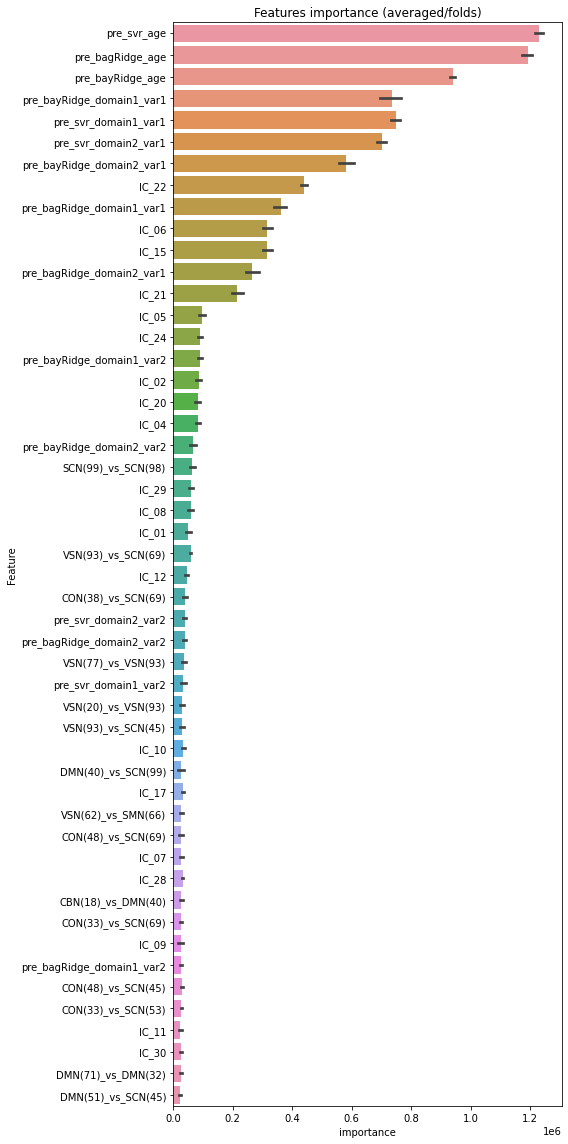

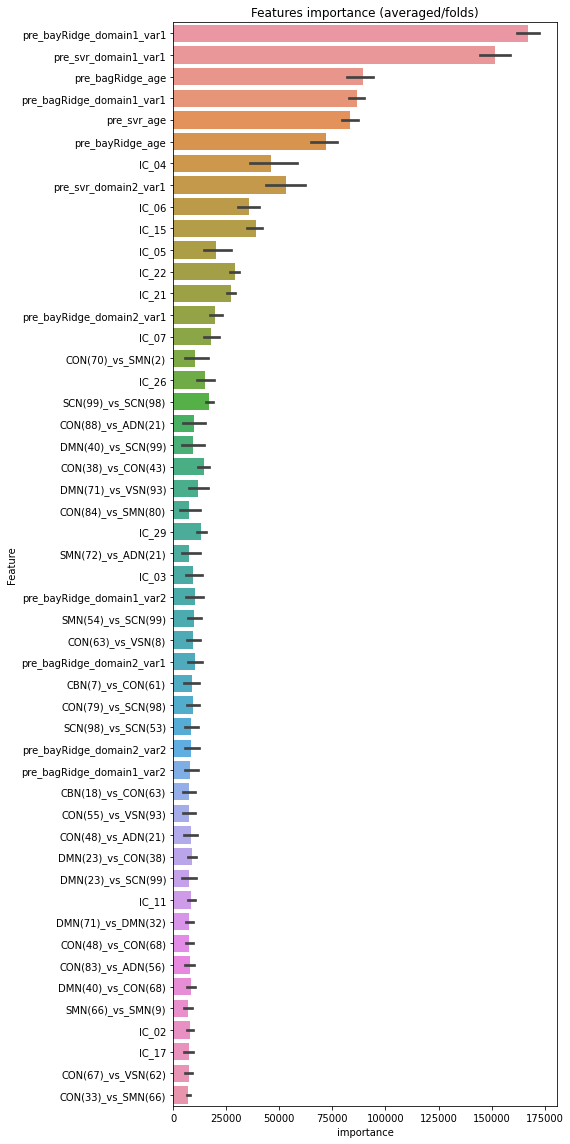

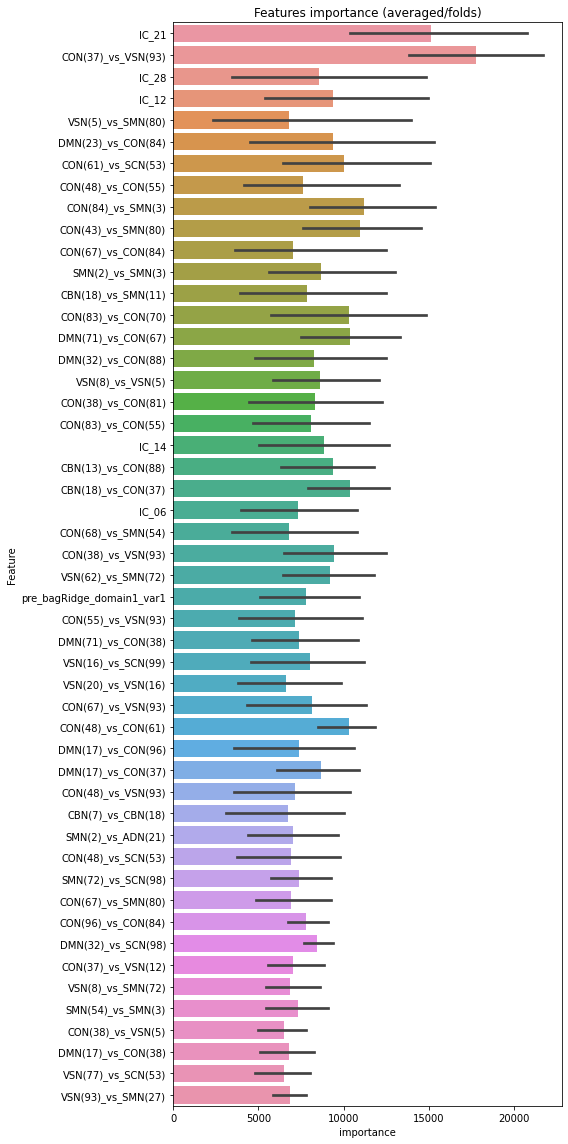

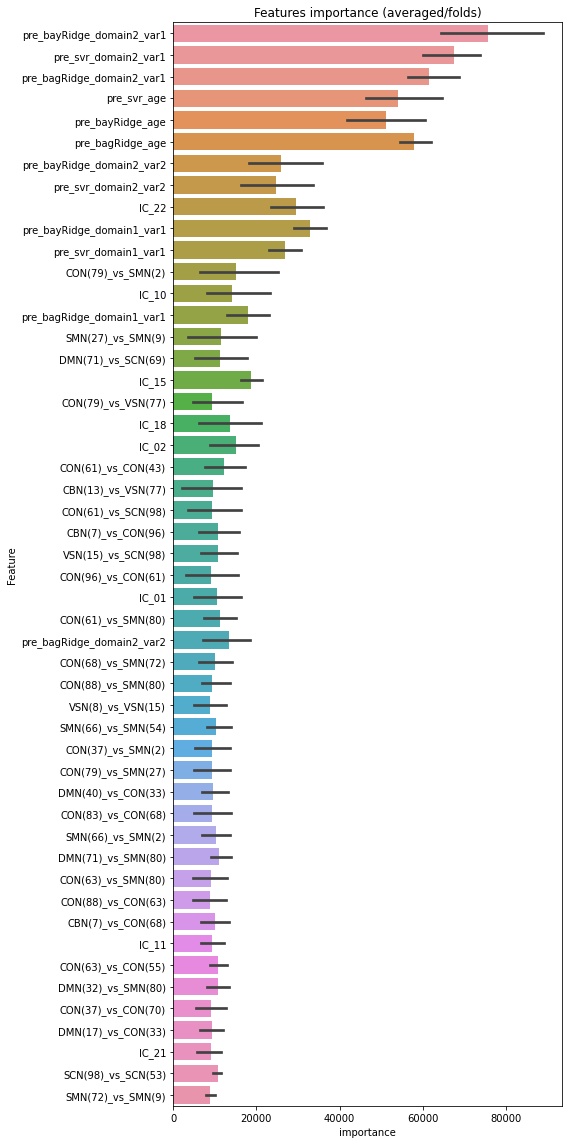

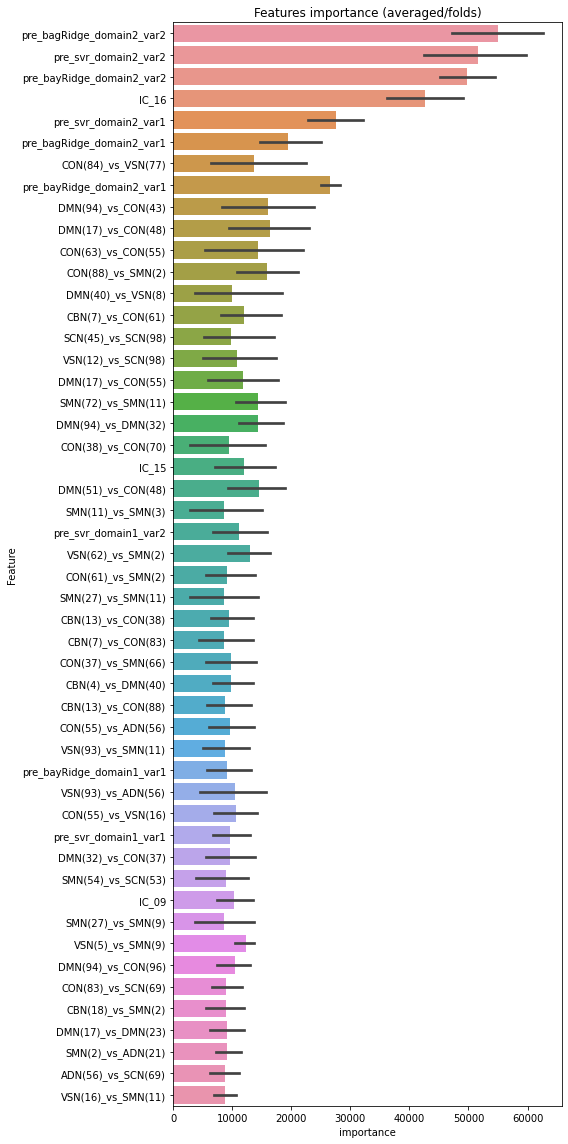

In [118]:
layer2_pred_train_targets_lgb = {}
layer2_pred_test_targets_lgb = {}
overal_score = 0

print("N_FOLD:{}".format(N_FOLD))

for target, w in [("age", 0.3),
                  ("domain1_var1", 0.175),
                  ("domain1_var2", 0.175),
                  ("domain2_var1", 0.175),
                  ("domain2_var2", 0.175)]:
    
    train_df_2 = pred_train_dfs[pred_train_dfs[target].notnull()]
    
    train_x = train_df[train_df[target].notnull()].drop([ID]+TARGET_COLS, axis=1)
    train_x_2 = train_df_2.drop([ID]+TARGET_COLS, axis=1)
    train_x_2 = pd.concat([train_x, train_x_2], axis=1)
    #ss.fit(train_x_2)
    #train_x_2 = ss.transform(train_x_2)
    #train_x_2 = pd.DataFrame(train_x_2)
    
    test_x_2 = pred_test_dfs.drop(ID, axis=1)
    #test_x_2 = ss.transform(test_x_2)
    #test_x_2 = pd.DataFrame(test_x_2)
    
    train_y = train_df_2[target]
    
    print("-----{}-----".format(target))
    #train_x, train_y, test_x, target_name, param
    pred_train, preds_test, score_cv, fi = predict_cv_lgb(train_x=train_x_2,
                                                          train_y=train_y,
                                                          test_x=test_x_2,
                                                          target_name=target,
                                                          param=lgb_param)
    show_feature_importance(fi, target)
    overal_score += w*score_cv
    layer2_pred_train_targets_lgb[target] = pred_train
    layer2_pred_test_targets_lgb[target] = preds_test
print('--------------------------------------------')
print("Overal score:", np.round(overal_score, 8))

In [134]:
train_y

0       51.427998
1       58.311361
2       62.536641
3       69.993075
4       34.096421
          ...    
5872    54.640179
5873    54.019517
5874    50.679885
5875    46.870235
5876    50.383078
Name: domain2_var2, Length: 5838, dtype: float64

In [128]:
#pred_train_targets_df = pd.DataFrame(layer2_pred_train_targets_lgb)
pred_test_targets_df = pd.DataFrame(layer2_pred_test_targets_lgb)

# Submit

In [119]:
test_df = pd.concat([test['Id'], pred_test_targets_df], axis=1)

In [120]:
test_df

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10003,57.277173,48.902719,59.604744,49.166154,56.201002
1,10006,62.225247,54.251414,58.417728,49.379944,51.784544
2,10010,37.151168,50.050625,59.449547,45.502617,52.647155
3,10011,51.249614,52.089598,59.673240,47.195586,50.599439
4,10012,52.133715,55.197381,57.916459,46.060805,56.884844
...,...,...,...,...,...,...
5872,21745,39.921680,50.774636,59.133815,45.692795,53.023727
5873,21748,54.204070,57.345042,59.246141,48.603110,51.048820
5874,21749,40.112965,46.884474,59.818693,45.974274,52.516174
5875,21751,40.363149,50.894871,59.312741,45.832426,53.811222


In [121]:
test_df.describe()

,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
count,5877.000000,5877.000000,5877.000000,5877.000000,5877.000000
mean,49.101251,51.578842,59.260423,47.010165,52.043045
std,10.253920,3.248679,0.609360,2.268347,1.805583
min,16.523534,40.566204,56.705429,39.276899,44.441306
25%,41.717775,49.412594,58.862905,45.453390,50.829426
50%,48.786756,51.636266,59.274635,46.951681,52.020657
75%,56.369883,53.822229,59.675267,48.573986,53.233682
max,83.799690,63.655703,61.563072,55.509670,59.140735


In [122]:
sub_df = pd.melt(test_df[["Id", "age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]], id_vars=["Id"], value_name="Predicted")
sub_df["Id"] = sub_df["Id"].astype("str") + "_" +  sub_df["variable"].astype("str")

sub_df = sub_df.drop("variable", axis=1).sort_values("Id")
assert sub_df.shape[0] == test_df.shape[0]*5
sub_df.head(10)

,Id,Predicted
0,10003_age,57.277173
5877,10003_domain1_var1,48.902719
11754,10003_domain1_var2,59.604744
17631,10003_domain2_var1,49.166154
23508,10003_domain2_var2,56.201002
1,10006_age,62.225247
5878,10006_domain1_var1,54.251414
11755,10006_domain1_var2,58.417728
17632,10006_domain2_var1,49.379944
23509,10006_domain2_var2,51.784544


In [123]:
sub_df.to_csv("submission_5fold_stacking.csv", index=False)